In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

import density_plot
from config import plot_path, parameter
import runner

In [3]:
Omega_a_h_sq_harm, theta_i_s_harm, f_a_s_harm = runner.load_data("harmonic.npz")
Omega_a_h_sq, theta_i_s, f_a_s = runner.load_data("cosine.npz")

## Polynomial

In [4]:
# def fit_fn(f_a, A, q): return np.log10(A) + q*np.log10(f_a)
def fit_fn(log_f_a, log_A, q, B_over_A, p_minus_q): 
    return log_A + q * log_f_a + np.log(1 + B_over_A * (10**log_f_a)**p_minus_q) 
theta_i_index = 0
Omega_unit = 1e-15
Omega = Omega_a_h_sq_harm[theta_i_index, :] / Omega_unit
f_a_unit = 1e14
f_a = f_a_s / f_a_unit
params, cov = opt.curve_fit(fit_fn, np.log10(f_a), np.log10(Omega), p0=(-5, 1, 1, 0), maxfev=5000)
err = np.sqrt(np.diag(cov))
log_A, q, B_over_A, p_minus_q = params
print(params, "+/-\n", err)
A = 10 ** log_A
B = B_over_A * A
p = p_minus_q + q
print("A =", A)
print("q =", q, "vs 7/6 =", 7/6)
print("B =", B)
print("p =", p, "vs 3/2 =", 3/2)

[ -4.08954531e+00   1.17205231e+00   9.95913534e-19   1.25806602e+00] +/-
 [  2.15836137e-02   2.49729782e-03   9.56974022e-18   2.98878524e-01]
A = 8.13681960111e-05
q = 1.17205230807 vs 7/6 = 1.1666666666666667
B = 8.1035687623e-23
p = 2.43011832792 vs 3/2 = 1.5


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


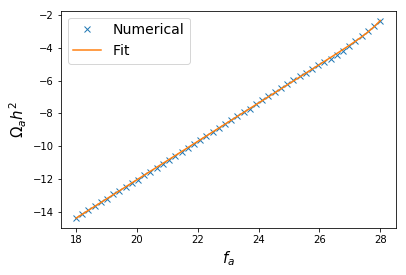

In [5]:
plt.plot(np.log10(f_a) + np.log10(f_a_unit), np.log10(Omega) + np.log10(Omega_unit), "x", label="Numerical")
plt.plot(np.log10(f_a) + np.log10(f_a_unit), fit_fn(np.log10(f_a), *params) + np.log10(Omega_unit), label="Fit")
plt.xlabel("$f_a$", fontsize=15)
plt.ylabel(r"$\Omega_a h^2$", fontsize=15)
plt.legend(fontsize=14)
plt.show()


## Rational

[  1.00000000e-04   1.16666667e+00   1.00000000e+00   1.00000000e+12
   1.00000000e-03] 
 [  2.76009682e-05   1.38342783e+00   2.35546078e+00   3.45831909e+17
   3.65257046e+02]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':


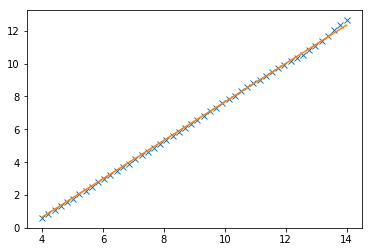

In [34]:
# def fit_fn(f_a, A, S, C, f_star, q):
def fit_fn(log_f_a, A, S, C, f_star, q):

    # P = S * (1 + C * (f_a / f_star)**q) / (1 + (f_a / f_star)**q)
    P = S * (1 + C * (10**log_f_a / f_star)**q) / (1 + (10**log_f_a / f_star)**q)
    # return np.log10(A) + P * np.log10(f_a)
    return np.log10(A) + P * log_f_a

# params, cov = opt.curve_fit(fit_fn, f_a, np.log10(Omega), p0=(1e-4, 7/6, 1, 1e12, 1e-3))
params, cov = opt.curve_fit(fit_fn, np.log10(f_a), np.log10(Omega), p0=(1e-4, 7/6, 1, 1e12, 1e-3))

err = np.diag(np.sqrt(cov))
plt.plot(np.log10(f_a), np.log10(Omega), "x")
# plt.semilogx(f_a, fit_fn(f_a, *params))
plt.plot(np.log10(f_a), fit_fn(np.log10(f_a), *params))

# plt.xlim((1e12, np.max(f_a)))
print(params, "\n", err)

In [128]:
from ipywidgets import interact
import ipywidgets 

In [135]:
N = 20
@interact
def fn(S=(0.2, 2.), C=(0., 2.), f_s=(0., 10.), q=(0., 25.)):
    f = np.linspace(0, 10, 300)
    plt.plot(f, S * (1 + C / S * (f / f_s)**q) / (1 + (f / f_s)**q))

interactive(children=(FloatSlider(value=1.1, description='S', max=2.0, min=0.2), FloatSlider(value=1.0, description='C', max=2.0), FloatSlider(value=5.0, description='f_s', max=10.0), FloatSlider(value=12.5, description='q', max=25.0), Output()), _dom_classes=('widget-interact',))